## Plotting unstructured satellite data

In many cases the data being used is not structured enough to be described by a grid definition. The examples below demonstrates some earthkit tools which make it possible to effectively plot such data. We primarily use some level-2 satellite data, which is provided as a 1-dimensional vector of points, each with a latitude and longitude value.

First we import the earthkit packages and define a Style that we will use in all the plots of this example.

In [1]:
import earthkit.data
import earthkit.plots

LEVELS = [i for i in range(390, 431, 4)]
STYLE = earthkit.plots.styles.Style(
    levels=LEVELS,
    extend="both",
    colors="Spectral_r",
)

This example use some sample test data which is a collection of satellite soundings from the IASI instrument on the METOP-C satellite from January 2021. Below we download and open the data with earthkit.

In [2]:
data = earthkit.data.from_source(
    "url",
    "https://get.ecmwf.int/repository/test-data/earthkit-plots/CO2_iasi_metop_c_nlis_2021_01.nc",
)
data_xr = data.to_xarray()
data_xr


<xarray.Dataset> Size: 11MB
Dimensions:       (sounding_dim: 381003)
Coordinates:
    latitude      (sounding_dim) float32 2MB dask.array<chunksize=(381003,), meta=np.ndarray>
    longitude     (sounding_dim) float32 2MB dask.array<chunksize=(381003,), meta=np.ndarray>
    time          (sounding_dim) datetime64[ns] 3MB dask.array<chunksize=(381003,), meta=np.ndarray>
  * sounding_dim  (sounding_dim) int64 3MB 0 1 2 3 ... 381000 381001 381002
Data variables:
    co2           (sounding_dim) float32 2MB dask.array<chunksize=(381003,), meta=np.ndarray>
Attributes: (12/36)
    title:                     NLIS
    institution:               Laboratoire de Météorologie Dynamique (LMD) - ...
    source:                    
    history:                   
    reference:                 Crevoisier et al., ACP, 2009, 2013
    tracking_id:               0ecf28e1-68ca-4e4c-8db9-3fbc1ebdfeca
    ...                        ...
    time_coverage_resolution:  P1D
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   ESA CCI Data Policy: free and open access
    platform:                  Metop-C
    sensor:                    IASI
    spatial_resolution:

The xarray reporesentation above shows how this `co2` data is stored in a single dimension, `sounding_dim`, with the `latitude`, `longitude` and `time` coordinates also stored along this dimensions.

### Scatter plot

First we will plot this data as a scatter plot, this gives a good feel for the data, however, it does not handle the overlapping points well.

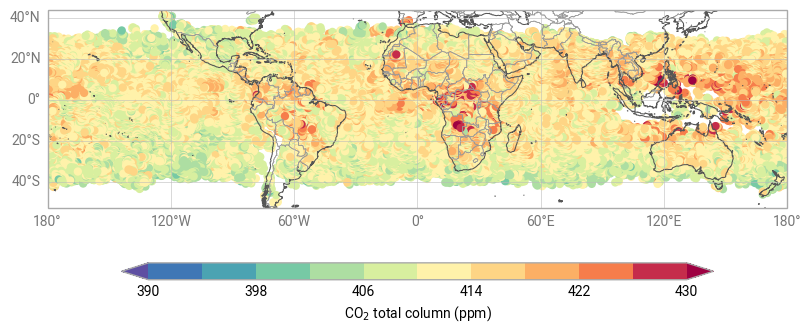

In [3]:
chart = earthkit.plots.Map()

chart.scatter(
    z = data_xr.co2.values,
    x = data_xr.longitude.values,
    y = data_xr.latitude.values,
    style=STYLE,
    linewidths=0,
)

chart.coastlines()
chart.borders()
chart.gridlines()

chart.legend(label="CO$_2$ total column (ppm)")

chart.show()

### Interpolate

`earthkit` allows us to interpolate the data to a two dimension grid so that we can plot as a contour or a meshgrid. This can by providing interpolation options via the `interpolate` kwarg, the default interpolation configuration can be used with `interpolate=True`.

The default interpolation approach is to detect the resolution of the data based on the median spacing of closest point distancem and then resample on a two dimensional grid in the projection of the plot projection.

:warning: If you do not provide any explicit interpolation information, a warning is produced by `earthkit-plots` indicating that interpolation is taking place using the default options.


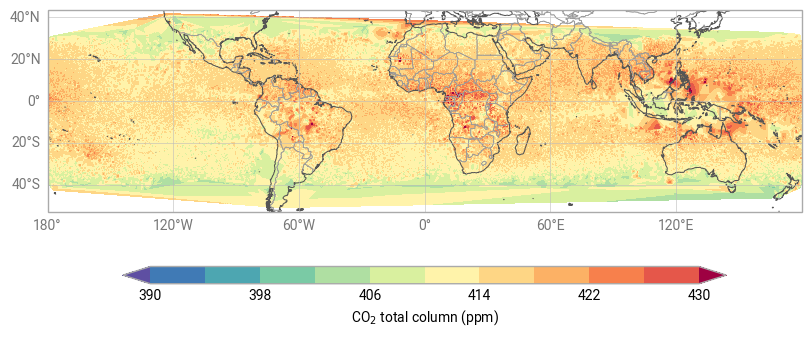

In [4]:
chart = earthkit.plots.Map()

chart.contourf(
    z = data_xr.co2.values,
    x = data_xr.longitude.values,
    y = data_xr.latitude.values,
    style=STYLE,
    interpolate=True,
)

chart.coastlines()
chart.borders()
chart.gridlines()

chart.legend(label="CO$_2$ total column (ppm)")

chart.show()

The default interpolation option may be computationally expensive. It is possible to speed things up by defining the interpolation options. This not only skips the resolution detection, but also allows the user to select a grid which is faster to interpolate to.


The interpolation kwarg is handled behind the scenes as the [`plots.resample.Interpolate`](../../_api/plots/resample/index.html#plots.resample.Interpolate) class. You can provide this field either as an instantiated Interpolate class, are as a dictionary of kwargs to instantiate that class. Note that using `interpolate=True` is equivalent to `interpolate=Interpolate()` or `interpolate=dict()`.


In the example below we set `target_shape=1000`, this will interpolate the data to a `1000 x 1000` grid before passing to `contourf`. It is also possible to pass the `target_shape` as a two element tuple defining the number of points in the x and y dimensions as `(n_x_points, n_y_points)`. Alternatively, you could set the `target_resolution` for the interpolation, this is in the units of the target projection and can be provided a single `float` value to define the resolution in both x and y, or a tuple of two floats defining different resolutions in the x and y dimensions, `(x_resolution, y_resolution)`. Some commented out examples are given below.


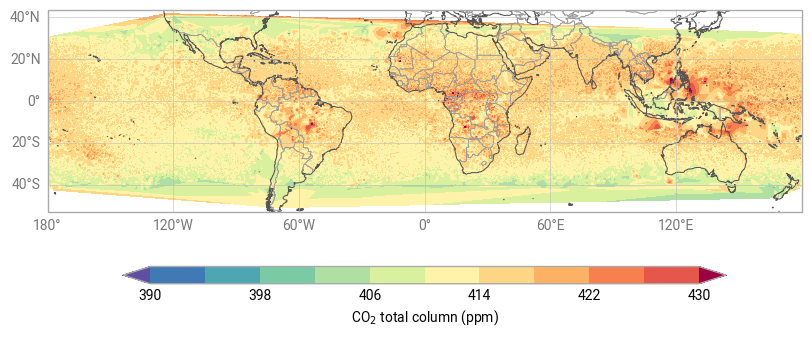

In [5]:
chart = earthkit.plots.Map()

chart.contourf(
    z = data_xr.co2.values,
    x = data_xr.longitude.values,
    y = data_xr.latitude.values,
    style=STYLE,
    interpolate=dict(target_shape=1000),              # A target shape with n_x = n_y = 1000
    # interpolate=dict(target_shape=(1000, 500)),     # A target shape with n_x = 1000 and n_y = 500
    # interpolate=dict(target_resolution=0.1),        # A target resolution of 0.1 degrees in both x and y
    # interpolate=dict(target_resolution=(0.2, 0.1)), # A target resolution of 0.2 degrees in x and 0.1 degrees in y
)

chart.coastlines()
chart.borders()
chart.gridlines()

chart.legend(label="CO$_2$ total column (ppm)")

chart.show()

### Distance threshold

The satellite level-2 data we are looking at has large data gaps, this has resulted in unrealistic interpolation patterns where there is no data. To avoid this, we can use the `distance_threshold` option in our Interpolate class. This sets a minimum threshold for the distance to an input data point for a grid cell to be included in the interpolated grid. In the context of this unstructured data example, a plot cell will only be plotted if there is at least one data point within the `distance_threshold`.

In the example below, `distance_threshold` is set to `auto` , this means that earthkit-plots will try to determine a sensible distance based on the data provided and the resolution of the plot produced. Alternatively, it can be defined explicitly as either a numeric value which represent a distance in the spatial units of the plotting projection (e.g. degrees for `PlateCarre`), or a string of the form `N cells"`, where `N` is the number of plotting cells that are used in the interpolation.

:warning: `auto` is provided as a convenience method and the exact implementation may change in the future.

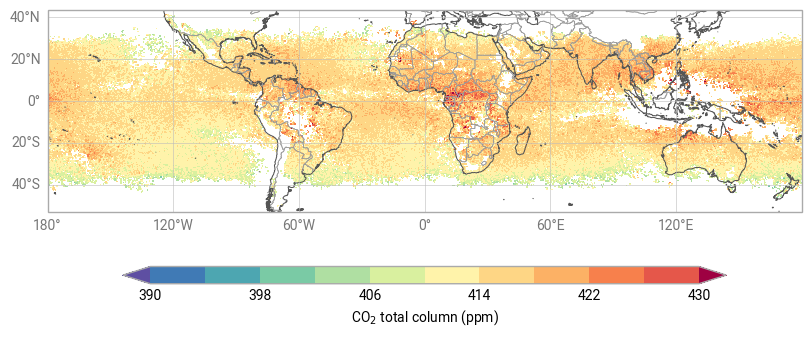

In [6]:
chart = earthkit.plots.Map()

chart.contourf(
    z = data_xr.co2.values,
    x = data_xr.longitude.values,
    y = data_xr.latitude.values,
    style=STYLE,
    interpolate=dict(distance_threshold="auto")
)

chart.coastlines()
chart.borders()
chart.gridlines()

chart.legend(label="CO$_2$ total column (ppm)")

chart.show()